## 0. Imports

In [ ]:
%reload_ext autoreload
%autoreload 2
%cd ../

In [ ]:
!pwd # need to be located in the root of the repo

In [ ]:
import json

from PIL import Image

import torch
from diffusers.utils import make_image_grid

import src.sdxl_custom_pipeline as sdxl_pipeline
from src.custom_dca import patch_pipe, reset_patched_unet

DEVICE=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
SEED=42

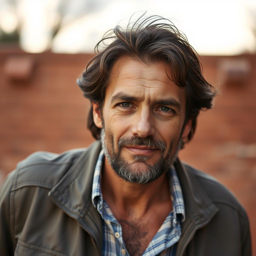

In [29]:
id_image = "data/evaluation_ds_v2/id_photos/middle_age_man-4.png"
prompt_style = "Cubist-inspired portait painting; person solving a puzzle"
prompt_real = "Person in a sprawling vineyard harvesting grapes"
config_path = "configs/fastface/am1_and_dcg.json"

Image.open(id_image).resize((256, 256))

## 1. Inference


In [30]:
config = json.load(open(config_path))

dcg_kwargs = config["pipe_kwargs"]["dcg_kwargs"]
dcg_kwargs

{'dcg_type': 3,
 'term_preproc': '',
 'term_postproc': 'rescale',
 'rescale': 0.75,
 'a_scheduler': 'custom',
 'b_scheduler': 'custom',
 'sch_kwargs': {'custom': {'a': [1.0, 1.5, 1.5, 1.0],
   'b': [1.0, 3.0, 3.0, 1.0]}},
 'return_norms': False}

In [31]:
am_patch_kwargs = config["am_patch_kwargs"]
am_patch_kwargs

{'target_parts': ['down', 'up'],
 'target_tokens': [0, 1, 2, 3],
 'target_tsteps': [0, 1, 2, 3],
 'am_transforms': ['pow', 'scale'],
 'inverse_neg_transforms': False,
 'apply_schedule': False,
 'apply_adain': False}

In [ ]:
# when run for first time, will take some time to download all weights
# NOTE: if change to turbo ckpt, remember to change hw to 512 in pipe_kwargs
config["model_name"] = "hyper" # specify desired model
fastface_pipe = sdxl_pipeline.name2pipe[config["method"]](config, DEVICE)

### Style prompt

In [ ]:
images = []
NUM_IMAGES = 4

fastface_pipe.set_ip_adapter_scale(config["ip_adapter_scale"])
fastface_pipe.set_adapters(["faceid_0"], [config["faceid_lora_scale"]])
patch_pipe(fastface_pipe, **config["am_patch_kwargs"])

with torch.no_grad():
    generator = torch.Generator(device=DEVICE).manual_seed(SEED)
    for _ in range(NUM_IMAGES):
        img = fastface_pipe.execute(
            face_image=id_image,
            prompt=prompt_style,
            generator=generator,
            pipe_kwargs=config["pipe_kwargs"],
            after_hook_fn=reset_patched_unet
        )
        images.append(img.resize((512, 512)))

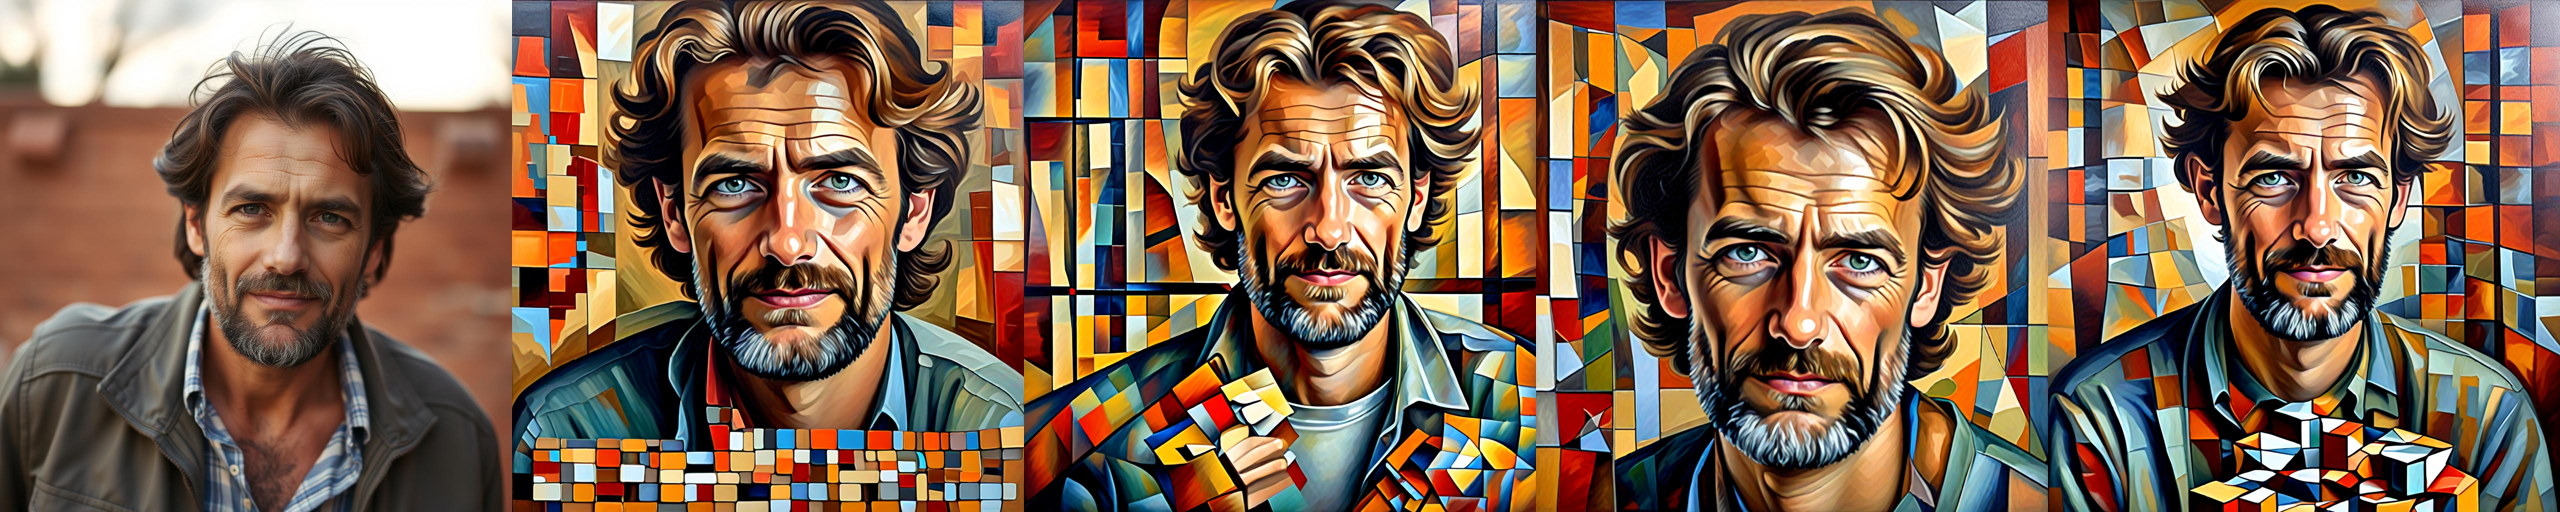

In [34]:
make_image_grid([Image.open(id_image).resize((512,512))] + images, rows=1, cols=NUM_IMAGES+1)

### Realistic prompt

In [ ]:
images = []
NUM_IMAGES = 4

fastface_pipe.set_ip_adapter_scale(config["ip_adapter_scale"])
fastface_pipe.set_adapters(["faceid_0"], [config["faceid_lora_scale"]])
patch_pipe(fastface_pipe, **config["am_patch_kwargs"])

with torch.no_grad():
    generator = torch.Generator(device=DEVICE).manual_seed(SEED)
    for _ in range(NUM_IMAGES):
        img = fastface_pipe.execute(
            face_image=id_image,
            prompt=prompt_real,
            generator=generator,
            pipe_kwargs=config["pipe_kwargs"],
            after_hook_fn=reset_patched_unet
        )
        images.append(img.resize((512, 512)))

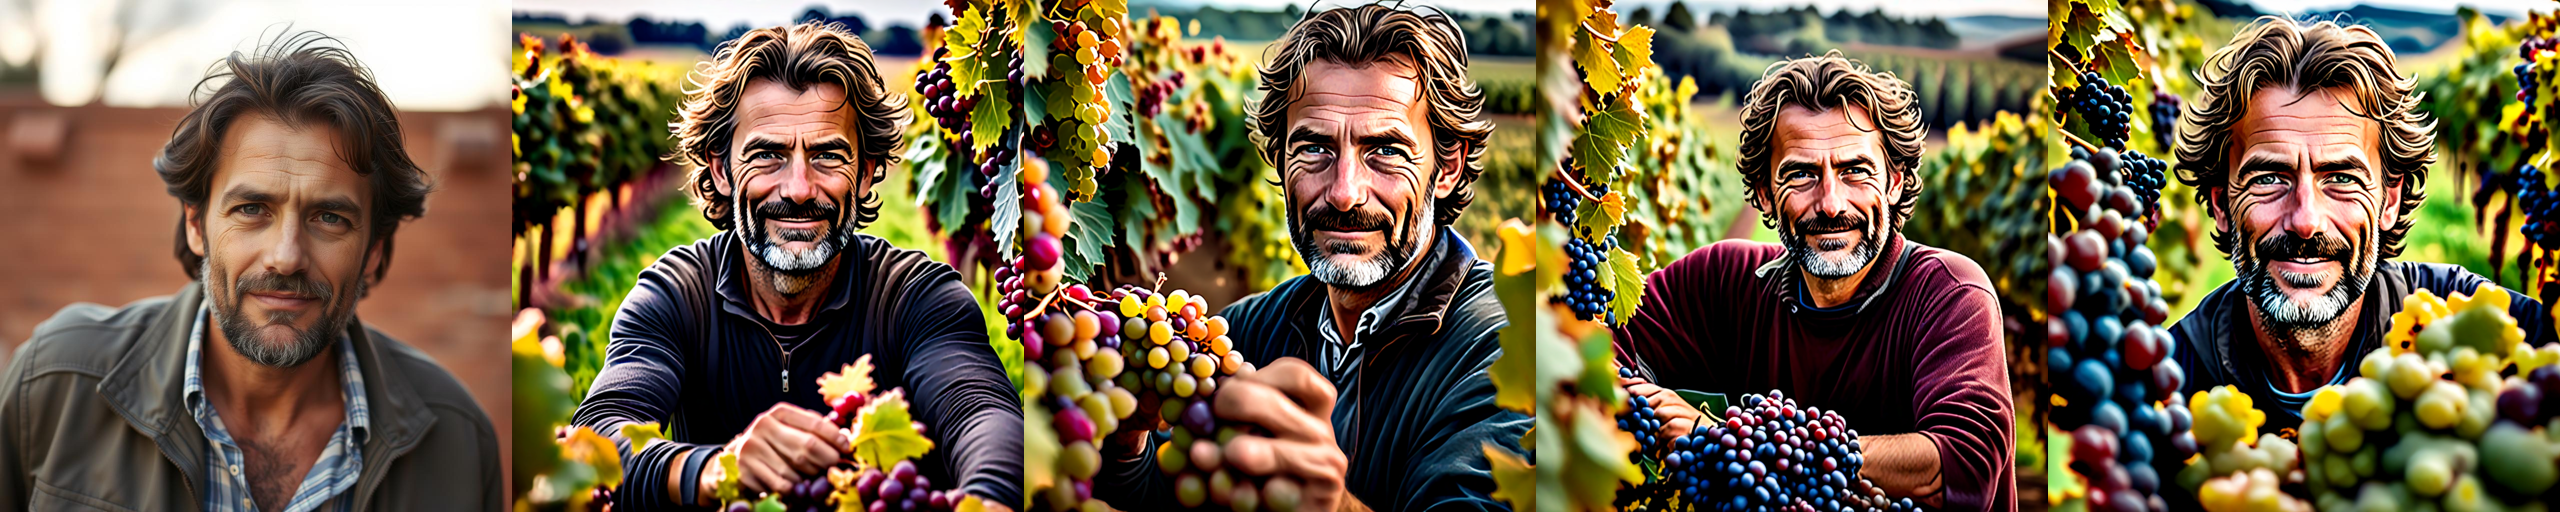

In [36]:
make_image_grid([Image.open(id_image).resize((512,512))] + images, rows=1, cols=NUM_IMAGES+1)